In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:

# df.set_index('timestamp', inplace=True)

# per_second = df.groupby(pd.Grouper(freq='1S')).sum()

In [2]:
data_path = '../data/postprocessed/PC/'

mapping_table = {
    'backprop': 'Backpropagation algorithm',
    'gaussian': 'Gaussian Elimination',
    'gpu': 'Stream Cluster',
    'lenet': 'Lenet5',
    'gpuburn': 'GPU-burn'
}

data_sheet_PC = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if not file.endswith('_telemetry.csv') and not file.startswith('srad')]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    data_sheet_PC=pd.concat([data_sheet_PC, df], ignore_index=True)

data_sheet_telemetry = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if file.endswith('_telemetry.csv') and not file.startswith('srad')]:
    csv_full_path = os.path.join(data_path, csv_name)
    # print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]

    data_sheet_telemetry=pd.concat([data_sheet_telemetry, df], ignore_index=True)

../data/postprocessed/PC/backprop_10.csv
../data/postprocessed/PC/backprop_1.csv
../data/postprocessed/PC/lenet_30.csv
../data/postprocessed/PC/gpuburn_7.csv
../data/postprocessed/PC/gaussian_7.csv
../data/postprocessed/PC/gpuburn_5.csv
../data/postprocessed/PC/gpuburn_3.csv
../data/postprocessed/PC/backprop_50.csv
../data/postprocessed/PC/gpuburn_20.csv
../data/postprocessed/PC/gaussian_80.csv
../data/postprocessed/PC/gpuburn_30.csv
../data/postprocessed/PC/backprop_15.csv
../data/postprocessed/PC/lenet_80.csv
../data/postprocessed/PC/gaussian_5.csv
../data/postprocessed/PC/backprop_3.csv
../data/postprocessed/PC/gaussian_15.csv
../data/postprocessed/PC/backprop_20.csv
../data/postprocessed/PC/backprop_80.csv
../data/postprocessed/PC/gaussian_10.csv
../data/postprocessed/PC/gpuburn5min_1.csv


KeyError: 'gpuburn5min'

### Before preprocessing it's better setting up the timeframe windows

In [38]:
data_sheet_PC.columns

Index(['session_id', 'duration_ms', 'location', 'metric_name',
       'rollup_operation', 'range_name', 'metric_value', 'Range', 'App_name'],
      dtype='object')

In [39]:
data_sheet_PC['timestamp_ms'] = data_sheet_PC.groupby(by=['location', 'metric_name', 'range_name', 'Range', 'App_name'])['duration_ms'].cumsum()
print('-----------------------------')
print(data_sheet_PC.isna().sum())
windowed_data_sheet = data_sheet_PC[['location', 'metric_name', 'range_name', 'Range', 'App_name', 'timestamp_ms', 'metric_value']]   \
    .groupby(by=['location', 'metric_name', 'range_name', 'Range', 'App_name'])\
        .rolling(window=12, on='timestamp_ms') \
            .mean()\
                .reset_index()
windowed_data_sheet['delta_metric_value']=windowed_data_sheet\
    .groupby(by=['location', 'metric_name', 'range_name', 'Range', 'App_name'])['metric_value']\
        .diff()
print('-----------------------------')
print(windowed_data_sheet.isna().sum())

# nan values are due to:
    # duration_ms: for the last session, the duration is not recorded because it first closes the sessions and then it starts
    # metric_value: for each group the first 12 elements of the sliding window are NaN + consider the values in which timestamp_ms is NaN

# by dropping the rows containing NaN values we will lose only the first 12 values for each group and the last session
print('-----------------------------')
print(f'Before: {len(windowed_data_sheet)}')
windowed_data_sheet = windowed_data_sheet.dropna()
windowed_data_sheet.isna().sum()
print('-----------------------------')
print(f'After: {len(windowed_data_sheet)}')
print('--------------------------------')
windowed_data_sheet

-----------------------------
session_id              0
duration_ms         11550
location                0
metric_name             0
rollup_operation        0
range_name              0
metric_value            0
Range                   0
App_name                0
timestamp_ms        11550
dtype: int64
-----------------------------
location                   0
metric_name                0
range_name                 0
Range                      0
App_name                   0
level_5                    0
timestamp_ms           11550
metric_value          141162
delta_metric_value    149898
dtype: int64
-----------------------------
Before: 611289
-----------------------------
After: 457212
--------------------------------


,location,metric_name,range_name,Range,App_name,level_5,timestamp_ms,metric_value,delta_metric_value
14,dram,sectors_read,0,1,GPU-burn,325779,17508.0,1.511690e+08,447416.666667
15,dram,sectors_read,0,1,GPU-burn,325800,18789.0,1.507750e+08,-394000.000000
16,dram,sectors_read,0,1,GPU-burn,325821,20071.0,1.503801e+08,-394916.666667
17,dram,sectors_read,0,1,GPU-burn,325842,21364.0,1.499560e+08,-424083.333333
18,dram,sectors_read,0,1,GPU-burn,325863,22668.0,1.500704e+08,114416.666667
...,...,...,...,...,...,...,...,...,...
611279,sys,cycles_elapsed,99,100,Gaussian Elimination,480134,18560.0,1.850732e+05,1886.833333
611280,sys,cycles_elapsed,99,100,Gaussian Elimination,482234,19748.0,1.868801e+05,1806.916667
611281,sys,cycles_elapsed,99,100,Gaussian Elimination,484334,20939.0,1.886168e+05,1736.750000
611282,sys,cycles_elapsed,99,100,Gaussian Elimination,486434,22097.0,1.902000e+05,1583.166667


### HR preprocessing and split by location (Performance Counters)

In [40]:
location_mapping={
    'lts': 'L2 Cache',
    'sm': 'Streaming Multiprocessor',
    'smsp': 'Streaming Multiprocessor Subpartition',
    'sys': 'System (aggregated info)',
    'dram': 'Dynamic RAM'
}

metric_event_mapping= {
    'cycles_active': 'Active cycles',
    'warps_active': 'Active warps',
    'inst_executed_op_generic_atom_dot_alu': 'Atomic ALU operations',
    'cycles_elapsed': 'Total elapsed cycles',
    'inst_executed_op_generic_atom_dot_cas': 'CAS atomic operatiions on global memory',
    'inst_executed_op_global_red': 'Global reduction',
    'inst_executed': 'Executed instructions',
    'inst_executed_pipe_fma': 'Executed FMA instructions',
    'inst_executed_pipe_fp64': 'Executed Double Precision instructions',
    'inst_issued': 'Issued instructions',
    't_sectors_op_read_lookup_miss': 'miss',
    'warps_launched': 'Executing warps',
    'thread_inst_executed': 'Executed thread instructions',
    'inst_executed_op_local_st': 'Executed instructions involving local memory store (write)',
    'inst_executed_op_local_ld': 'Executed instruction involving local memory load (read)',
    'inst_executed_op_global_st': 'Executed instructions involving global memory store (write)',
    'inst_executed_op_global_ld': 'Executed instructions involving global memory load (read)',
    'sectors_write':'Written memory partition',
    'sectors_read':'Read memory partition'
}

windowed_data_sheet['HR_location'] = windowed_data_sheet['location'].map(location_mapping)
windowed_data_sheet = windowed_data_sheet.drop('location', axis=1)

windowed_data_sheet['HR_metric_name'] = windowed_data_sheet['metric_name'].map(metric_event_mapping)
windowed_data_sheet=windowed_data_sheet.drop('metric_name', axis=1)

df_l2 = windowed_data_sheet[windowed_data_sheet['HR_location']=='L2 Cache']
df_sm = windowed_data_sheet[windowed_data_sheet['HR_location']=='Streaming Multiprocessor']
df_smsp = windowed_data_sheet[windowed_data_sheet['HR_location']=='Streaming Multiprocessor Subpartition']
df_sys = windowed_data_sheet[windowed_data_sheet['HR_location']=='System (aggregated info)']
df_dram = windowed_data_sheet[windowed_data_sheet['HR_location']=='Dynamic RAM']

dfs = {
    'L2 Cache': df_l2, 
    'Streaming Multiprocessor': df_sm, 
    'Streaming Multiprocessor Subpartition': df_smsp, 
    'System (Aggregated info)': df_sys, 
    'Dynamic RAM': df_dram
    }

df_pivot_l2 = df_l2.pivot_table(
    index=["HR_location", "range_name", "Range", "App_name", "timestamp_ms"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm = df_sm.pivot_table(
    index=["HR_location", "range_name", "Range", "App_name", "timestamp_ms"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp = df_smsp.pivot_table(
    index=["HR_location", "range_name", "Range", "App_name", "timestamp_ms"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sys = df_sys.pivot_table(
    index=["HR_location", "range_name", "Range", "App_name", "timestamp_ms"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_dram = df_dram.pivot_table(
    index=["HR_location", "range_name", "Range", "App_name", "timestamp_ms"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'L2 Cache': df_pivot_l2, 
    'Streaming Multiprocessor': df_pivot_sm, 
    'Streaming Multiprocessor Subpartition': df_pivot_smsp, 
    'System (Aggregated info)': df_pivot_sys, 
    'Dynamic RAM': df_pivot_dram
    }

hue_order = ['Backpropagation algorithm', 'Gaussian Elimination', 'Lenet5', 'GPU-burn']

### HR preprocessing and split by location (Telemetry)

In [41]:
metrics_map = {
    'temperature_C':'Temperature [°C]',
    'util_gpu_percent': 'GPU Utilization [%]',
    'util_mem_percent':'GPU Memory Utilization [%]',
    'mem_used_MB':'Used Memory [MB]', 
    'mem_free_MB':'Free Memory [MB]', 
    'clock_sm_MHz':'Streaming Multiprocessor Clock Frequency [MHz]', 
    'clock_mem_MHz':'Memory Clock Frequency [MHz]', 
    'power_draw_W':'GPU Power Consumption [W]'
}
data_sheet_telemetry=data_sheet_telemetry.rename(columns=metrics_map)
data_sheet_telemetry=data_sheet_telemetry.drop(labels=['ecc_volatile_uncorrected', 'ecc_volatile_uncorrected', 'ecc_aggregate_corrected', 'ecc_aggregate_uncorrected', 'fan_speed_percent'], axis=1)

data_sheet_telemetry['delta_timestamp_ms'] = data_sheet_telemetry.groupby(by=['Range','App_name'])['timestamp_ns'].diff()/1e6
data_sheet_telemetry['Delta Temperature [°C]'] = data_sheet_telemetry.groupby(by=['Range','App_name'])['Temperature [°C]'].diff()
data_sheet_telemetry['Delta GPU Memory Utilization [%]'] = data_sheet_telemetry.groupby(by=['Range','App_name'])['GPU Memory Utilization [%]'].diff()
data_sheet_telemetry['Delta GPU Power Consumption [W]'] = data_sheet_telemetry.groupby(by=['Range','App_name'])['GPU Power Consumption [W]'].diff()

## Da una parte ho i dati dei PC e dall'altra la telemetria.
1. Nei dati dei PC il timestamp si ricava dalla duration
2. Nei dati di telemetria il timestamp è dato ma bisogna fare .diff().

Il problema è che questi non coincidono quindi devo fare una sorta di interpolazione per far coincidere i timestamp. O trovare il modo per joinare due dataframe con timestamp che non coincidono.

- Una volta fatto questo si deve solo capire come normalizzarli per averli in due scale diverse ma comparabili.
- In alternativa considera la possibilità di capire l'aumento di quali performance counters aumenta la temperatura.


In [42]:
windowed_data_sheet['HR_metric_name'].unique()

array(['Read memory partition', 'Written memory partition', 'miss',
       'Active cycles', 'Total elapsed cycles', 'Executed instructions',
       'Issued instructions', 'Active warps', 'Atomic ALU operations',
       'CAS atomic operatiions on global memory',
       'Executed instructions involving global memory load (read)',
       'Global reduction',
       'Executed instructions involving global memory store (write)',
       'Executed instruction involving local memory load (read)',
       'Executed instructions involving local memory store (write)',
       'Executed FMA instructions',
       'Executed Double Precision instructions',
       'Executed thread instructions', 'Executing warps'], dtype=object)

### Let's consider only gpuburn as application otherwise the plots will be too messy

/tmp/ipykernel_3822/901959632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  windowed_data_sheet_gpuburn['metric_full_name'] = windowed_data_sheet_gpuburn['HR_location'] + windowed_data_sheet_gpuburn['HR_metric_name']


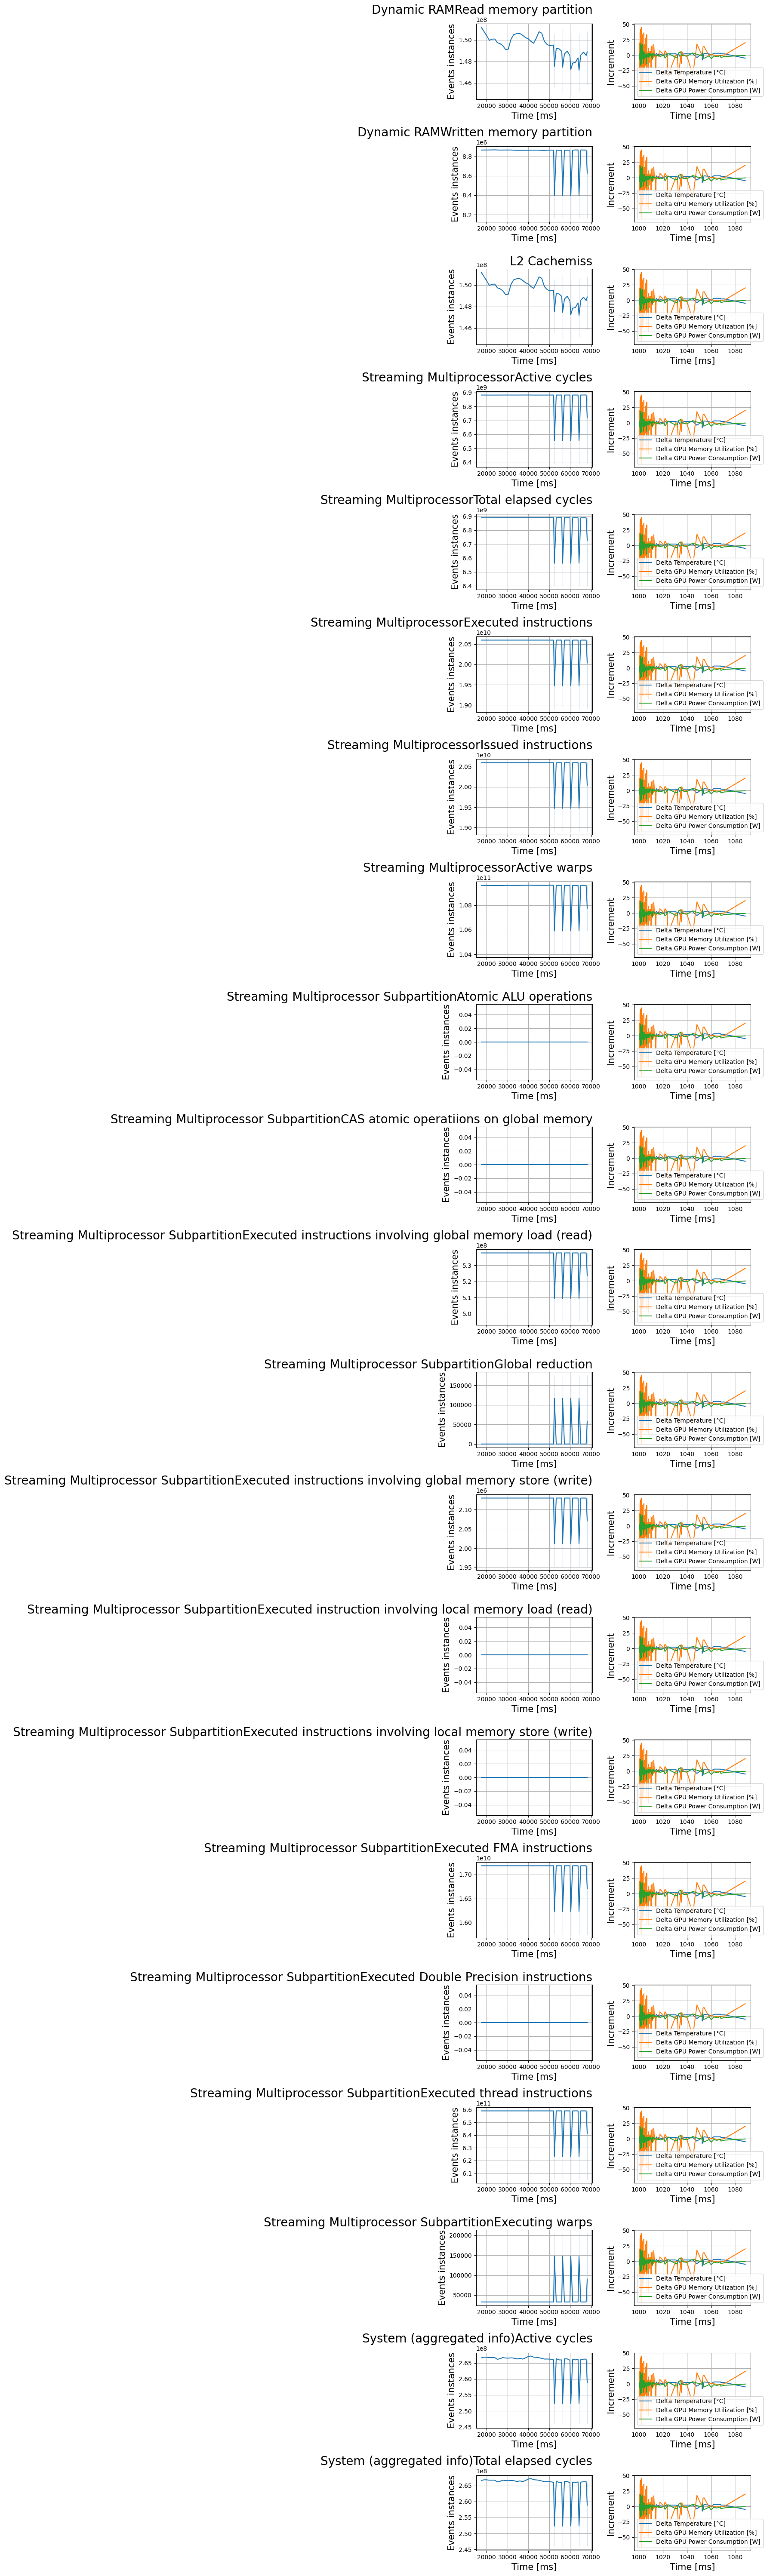

In [44]:
fig, ax = plt.subplots(21,2,figsize=(10,60))
windowed_data_sheet_gpuburn = windowed_data_sheet[windowed_data_sheet['App_name']=='GPU-burn']
data_sheet_telemetry_gpuburn = data_sheet_telemetry[data_sheet_telemetry['App_name']=='GPU-burn']
windowed_data_sheet_gpuburn['metric_full_name'] = windowed_data_sheet_gpuburn['HR_location'] + windowed_data_sheet_gpuburn['HR_metric_name']
for metric_idx in range(len(windowed_data_sheet_gpuburn['metric_full_name'].unique())):

    ## Telemetry
    sns.lineplot(data = data_sheet_telemetry, x='delta_timestamp_ms', y='Delta Temperature [°C]', ax = ax[metric_idx][1], label='Delta Temperature [°C]')
    sns.lineplot(data = data_sheet_telemetry, x='delta_timestamp_ms', y='Delta GPU Memory Utilization [%]', ax = ax[metric_idx][1], label='Delta GPU Memory Utilization [%]')
    sns.lineplot(data = data_sheet_telemetry, x='delta_timestamp_ms', y='Delta GPU Power Consumption [W]', ax = ax[metric_idx][1], label='Delta GPU Power Consumption [W]')
    ax[metric_idx][1].set_title('')
    ax[metric_idx][1].grid()
    # ax[metric_idx][1].set_yscale('log')
    ax[metric_idx][1].set_xlabel('Time [ms]', fontsize=15)
    ax[metric_idx][1].set_ylabel('Increment', fontsize=15)

    ## PCs
    metric_name = windowed_data_sheet_gpuburn['metric_full_name'].unique()[metric_idx]
    data = windowed_data_sheet_gpuburn[windowed_data_sheet_gpuburn['metric_full_name'] == metric_name]
    sns.lineplot(data = data, x='timestamp_ms', y='metric_value', ax = ax[metric_idx][0])
    ax[metric_idx][0].set_title(f"{windowed_data_sheet_gpuburn['metric_full_name'].unique()[metric_idx]}", fontsize=20, loc='right')
    ax[metric_idx][0].grid()
    # ax[metric_idx][0].set_yscale('log')
    ax[metric_idx][0].set_xlabel('Time [ms]', fontsize=15)
    ax[metric_idx][0].set_ylabel('Events instances', fontsize=15)
plt.tight_layout()

### Nei grafici precedenti calcola che gli assi x hanno due scale diverse (molto probabilmente, il cout che hai usato per modificare lo script in cpp non torna il tempo in millisecondi ma in nanosecondi o qualcosa del genere)

### Mix plots

In [28]:
windowed_data_sheet_gpuburn.columns

Index(['range_name', 'Range', 'App_name', 'level_5', 'timestamp_ms',
       'metric_value', 'delta_metric_value', 'HR_location', 'HR_metric_name',
       'metric_full_name'],
      dtype='object')

In [29]:
data_sheet_telemetry_gpuburn.columns

Index(['timestamp_ns', 'gpu_index', 'name', 'Temperature [°C]',
       'GPU Utilization [%]', 'GPU Memory Utilization [%]', 'mem_total_MB',
       'Used Memory [MB]', 'Free Memory [MB]',
       'Streaming Multiprocessor Clock Frequency [MHz]',
       'Memory Clock Frequency [MHz]', 'clock_graphics_MHz',
       'GPU Power Consumption [W]', 'ecc_volatile_corrected', 'Range',
       'App_name', 'delta_timestamp_ms', 'Delta Temperature [°C]',
       'Delta GPU Memory Utilization [%]', 'Delta GPU Power Consumption [W]'],
      dtype='object')

In [34]:
print(len(data_sheet_telemetry_gpuburn))
print(len(windowed_data_sheet_gpuburn))

1041
1134


/tmp/ipykernel_3822/43399038.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='metric_value', y='Temperature [°C]', ax = ax[metric_idx], label='Temperature [°C]', ci=False)
/tmp/ipykernel_3822/43399038.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='metric_value', y='Temperature [°C]', ax = ax[metric_idx], label='Temperature [°C]', ci=False)
/tmp/ipykernel_3822/43399038.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='metric_value', y='Temperature [°C]', ax = ax[metric_idx], label='Temperature [°C]', ci=False)
/tmp/ipykernel_3822/43399038.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='metric_value', y='Temperature [°C]', ax = ax[m

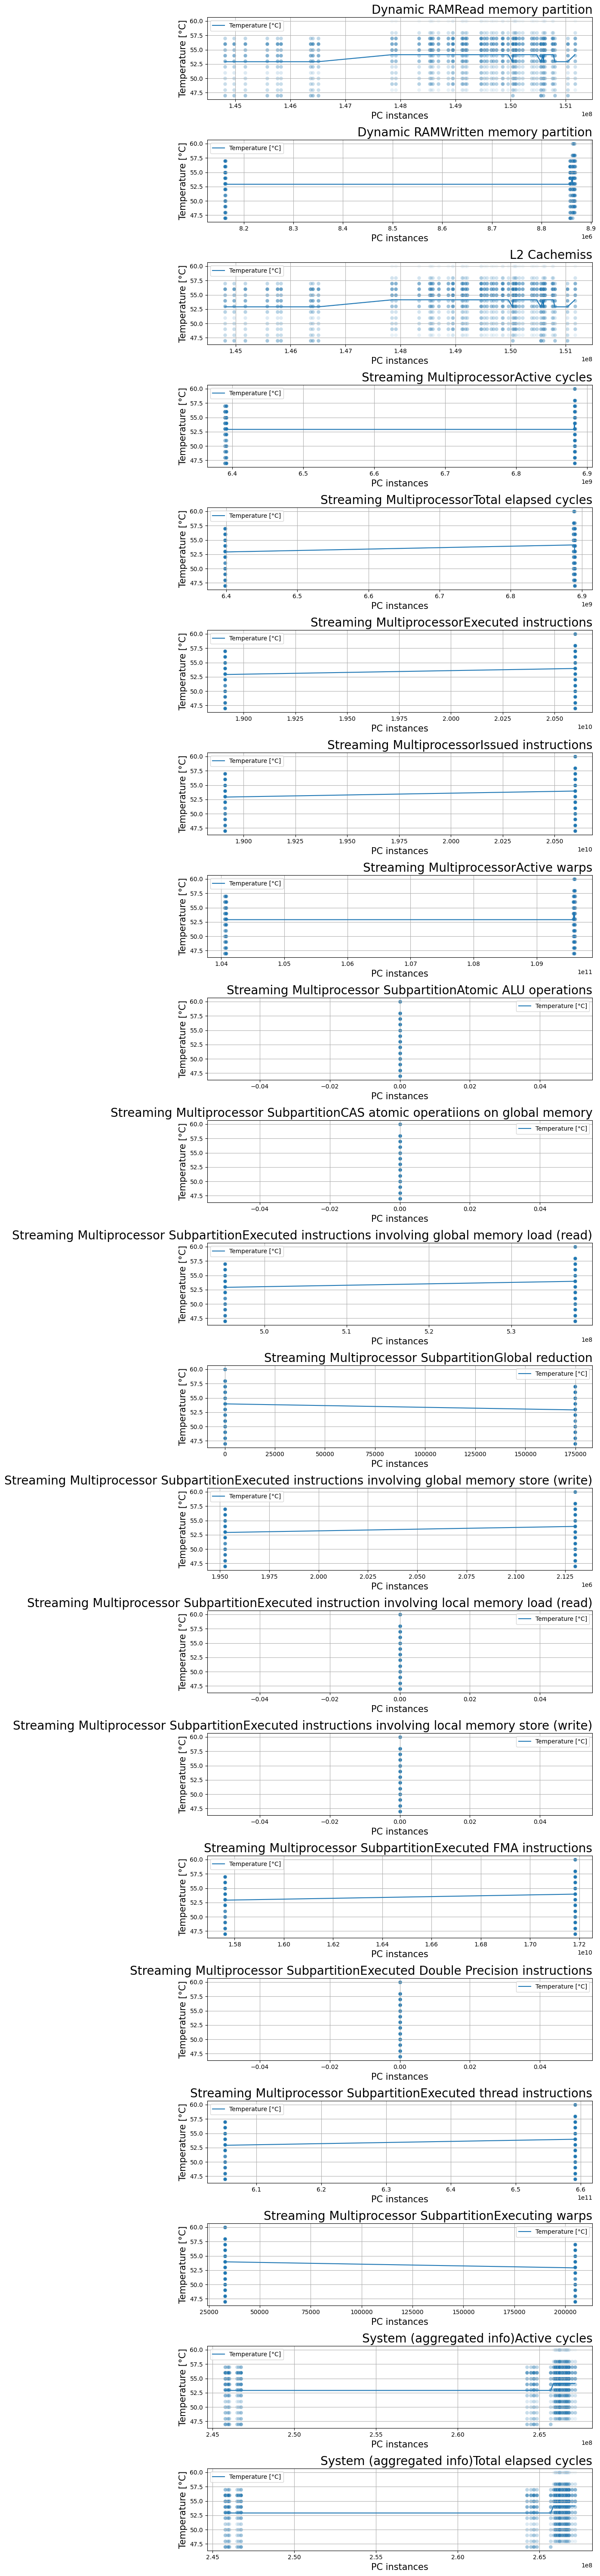

In [54]:
fig, ax = plt.subplots(21,1,figsize=(10,60))
merged = pd.merge(windowed_data_sheet_gpuburn, data_sheet_telemetry_gpuburn, on=['Range', 'App_name'])
for metric_idx in range(len(merged['metric_full_name'].unique())):

    ## Telemetry
    metric_name = merged['metric_full_name'].unique()[metric_idx]
    data = merged[merged['metric_full_name'] == metric_name]
    sns.lineplot(data = data, x='metric_value', y='Temperature [°C]', ax = ax[metric_idx], label='Temperature [°C]', ci=False)
    sns.scatterplot(data = data, x='metric_value', y='Temperature [°C]', ax = ax[metric_idx], label='', alpha=0.05)
    # sns.lineplot(data = data, x='metric_value', y='GPU Memory Utilization [%]', ax = ax[metric_idx], label='GPU Memory Utilization [%]')
    # sns.lineplot(data = data, x='metric_value', y='GPU Power Consumption [W]', ax = ax[metric_idx], label='GPU Power Consumption [W]')

    ax[metric_idx].set_title(f"{windowed_data_sheet_gpuburn['metric_full_name'].unique()[metric_idx]}", fontsize=20, loc='right')
    ax[metric_idx].grid()
    # # ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('PC instances', fontsize=15)
    ax[metric_idx].set_ylabel('Temperature [°C]', fontsize=15)
plt.tight_layout()